In [123]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [124]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.sparse.linalg import svds
from scipy.sparse import coo_array
import pywt
from scipy.sparse.linalg import LinearOperator, cg
import torch

In [125]:
# Load the MATLAB file
mat = scipy.io.loadmat('image_xyt.mat')

In [126]:
image=mat['image_xyt']

In [127]:
#function to display random images
def display_random_images(image: np.array,
                          frames: list=[10,20,30],
                          display_shape: bool = True,
                          seed: int = None):
    
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = frames

    # 5. Setup plot
    plt.figure(figsize=(60, 60))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image = image[:,:,targ_sample]
        # Plot adjusted samples
        plt.subplot(1, len(frames), i+1)
        plt.imshow(targ_image,cmap='gray')
        plt.axis("off")
        plt.title(f'Frame No:{targ_sample}',fontsize=25)

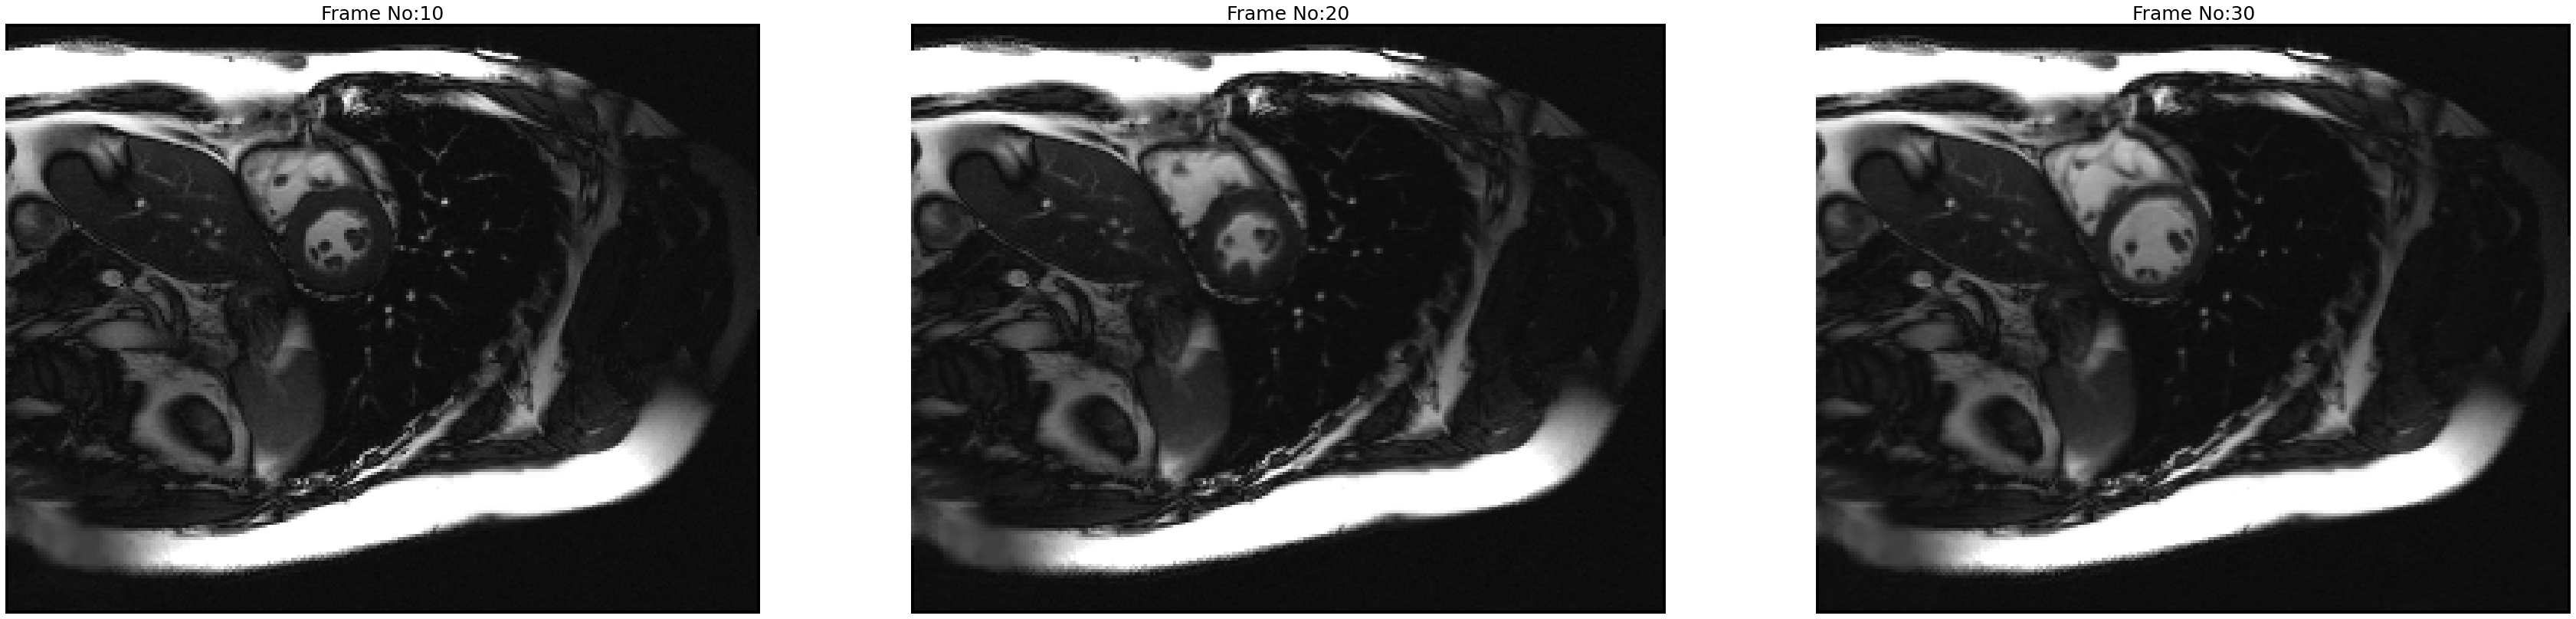

In [128]:
display_random_images(image)

In [129]:
# defines varibles
#Np: number of phase encodings
Np=image.shape[0]
#number of frequence encodings
Nf= image.shape[1]

#number of frames
Nfr=256
#Nnav: Number of navigator lines
Nnav  = 10;

In [82]:
#  form the k-t space sampling mask 
# Nsam number of sample in k space
Nsam = 32
#nav_ind: A vector containing the indices for navigator lines.
nav_ind = list(range(int(Np/2-Nnav/2),int(Np/2+Nnav/2)))

In [130]:
def tem_sampling_generation(Np, Nfr, Nnav, Nsam):
    """
    Generating the temporal sampling mask.
    
    Inputs:
    Np: number of phase encodings
    Nfr: number of temporal frames
    Nnav: number of phase encodings for navigator signal
    Nsam: number of samples acquired at each k-space location
    
    Output:
    temmask: temporal sampling mask
    """

    temmask = np.zeros((Np, Nfr))
    nav_ind = np.arange(Np // 2 - Nnav // 2, Np // 2 + Nnav // 2)

    for ii in range(Np):
        if ii in nav_ind:
            temmask[ii, :] = np.ones(Nfr)
        else:
            temp = np.zeros(Nfr)
            ind = np.random.choice(range(Nfr), size=Nfr, replace=False)
            temp[ind[:Nsam]] = 1
            temmask[ii, :] = temp
    temmask = np.where(temmask == 0, 0, 1)
    temmask = temmask.astype(bool)
    return temmask

In [131]:
Kraw = 1 / np.sqrt(Np * Nf) * np.fft.fft2(image, axes=(0,1))
# from the corteasi matrix 
image_xyt = np.reshape(image, (Np * Nf, Nfr), order='F')
Kraw_C = np.reshape(Kraw, (Np * Nf, Nfr), order='F')

In [132]:
#generatete mask
temmask=tem_sampling_generation(Np,image.shape[-1],Nnav, Nsam)
temmask=np.fft.fftshift(temmask,axes=0)
Mask=np.moveaxis(np.reshape(np.tile(temmask, Nfr),
                              (Np, Nf, Nfr), order="F"),
                   source=[0, 1, 2], destination=[0, 2, 1])
Mask=np.reshape(Mask,(Np*Nf, Nfr),order='F')

In [133]:
#undersampled K-space data
d = Kraw_C[Mask]

In [134]:
# navigator location of a single frame
nav_location = np.zeros((Np, 1))
nav_location[nav_ind] = 1

In [135]:
# calulate the navigator data obtained from all frames
fftshift_nav_location = np.fft.fftshift(nav_location, axes=0)
indices = np.where(fftshift_nav_location)

Navdata = Kraw[indices[0], :, :].reshape(Nnav * Nf, Nfr, order='F')

In [136]:
# obtain the top r right singular vectors from 
r = 32
_, _, Vt_r =svds(Navdata, k=r)

In [137]:
# define regularizer parameters
beta = 1e3
mu   = 2.5e-6

In [138]:
#intial value of Usr
Us_r0 = np.zeros((Np * Nf, r))

In [139]:
# Define the normal_oper function (using the provided implementation)
def normal_oper(Uk_r, Vt_r, Rind, Cind, Mask):
    N = Mask.shape[0]
    M = Mask.shape[1]
    r = Vt_r.shape[0]
    G = np.reshape(Uk_r, (N, r),order='F') @ Vt_r
    d = G[Mask]
    del G
    UU = coo_array((d, (Rind, Cind)), shape=(N, M)) @ Vt_r.conj().T
    UU = np.reshape(UU, (N * r),order='F')
    return UU

In [93]:
def ps_sparse_recon(d,
                   M,
                   Us_r,
                   Vt_r,
                   mu: float,
                   beta: float,
                   regularizer: str,
                   Np: int,
                   Nf: int,
                   Nfr: int):
    '''This code performs image reconstruction from highly undersampled data using
    joint partial separability (PS) and sparsity constraints
    
    Args:
        d: measured data undersampled  Size([1867776, 1])
        Mask: k-t space sampling mask Size([51200, 256])
        Us_r: initial value of Us_r Size([51200, 32])
        Vt_r: basis for the temporal subspace Size([32, 256])
        mu: regularization parameter 
        beta: initial value of continuation parameter
        regularizer: spa_reg for spatial sparsity regularization
        Np: number of phase encodings
        Nf: number of frequence encodings
        Nfr: number of temporal frames
    Return:
        Us_r: basis for the spatial subspace
    '''
    #tolerance for error
    tol = 1e-5
    #maximum number of iterations
    maxit = 200
    # size of temporal basis
    r= Us_r.shape[-1]
    # get the rows and column index of the non-zero mask
    Rind,Cind  = np.nonzero(Mask)
    # Create a sparse matrix and multiply it with Vt_r'
    bb = coo_array((d, (Rind, Cind)), shape=(Np * Nf, Nfr)) @ Vt_r.conj().T
    
    Uk_r = (1 / np.sqrt(Np * Nf)) * np.fft.fft2(Us_r.reshape(Np, Nf, r,order='F'), axes=(0, 1)).reshape(Np * Nf, r, order='F')
    Us_r_last=Us_r
    
    Vf_r = 1/np.sqrt(Nfr) * np.fft.fft(Vt_r, axis=1)
    #outer loop
    for i in range(0,5):
        print(f"The outerloop loop is {i}")
        for j in range(0,100):
            print(f"The inner loop is {j}")
            Us_r_Vf_r = Us_r@Vf_r
            Gs = np.multiply(np.array(torch.sgn(torch.from_numpy(Us_r_Vf_r))), np.maximum(np.abs(Us_r_Vf_r) - 1 / beta, 0)) @ Vf_r.conj().T
            Gk=(1 / np.sqrt(Np * Nf))*np.fft.fft2((np.reshape(Gs,(Np,Nf,r),order='F')),axes=(0,1))
            b = bb + mu * beta / 2 * np.reshape(Gk, (Np * Nf, r), order='F')
            # Solve the linear system using the PCG method
            #define the linear operator
            # Define a linear operator for the matrix-vector multiplication
            def funcd(x):
                result = normal_oper(x, Vt_r, Rind, Cind, Mask) + mu * beta / 2 * x
                return result
            A = LinearOperator((len(b)*r,len(b)*r), matvec=funcd)
            Uk_r, info = cg(A, b.flatten(order='F'), tol=tol, maxiter=maxit, x0=Uk_r.flatten(order='F'))
            print(info)
            Uk_r=np.reshape(Uk_r, (Np*Nf,r),order='F')
            Us_r = np.sqrt(Np * Nf) * np.fft.ifft2(Uk_r.reshape((Np, Nf, r), order='F'), axes=(0, 1),norm=None)
            Us_r=np.reshape(Us_r,(Np*Nf,r),order='F')
            relchange_Us = np.linalg.norm(Us_r.flatten(order='F') - Us_r_last.flatten(order='F')) / np.linalg.norm(Us_r_last.flatten(order='F'))
            Us_r_last = Us_r
            print("relchange",relchange_Us)
            if relchange_Us < 1e-4:
                    break
        beta = 10 * beta
    return Us_r

In [140]:
Us_r=ps_sparse_recon(d=d,
                    M=Mask,
                    Us_r=Us_r0,
                    Vt_r=Vt_r,
                    mu=mu,
                    beta=beta,
                    regularizer='xf_sparse',
                    Np=Np,
                    Nf=Nf,
                    Nfr=Nfr)

The outerloop loop is 0
The inner loop is 0
0


C:\Users\arpan\AppData\Local\Temp/ipykernel_16480/4264198202.py:64: RuntimeWarning: divide by zero encountered in double_scalars
  relchange_Us = np.linalg.norm(Us_r.flatten(order='F') - Us_r_last.flatten(order='F')) / np.linalg.norm(Us_r_last.flatten(order='F'))


relchange inf
The inner loop is 1
0
relchange 0.13740426666119634
The inner loop is 2
0
relchange 0.018796853565704465
The inner loop is 3
0
relchange 0.0
The outerloop loop is 1
The inner loop is 0
0
relchange 0.03496662105533483
The inner loop is 1
0
relchange 0.005762876599726748
The inner loop is 2
0
relchange 0.001997907027321679
The inner loop is 3
0
relchange 0.0
The outerloop loop is 2
The inner loop is 0
0
relchange 0.015351495509578348
The inner loop is 1
0
relchange 0.0049667017531048185
The inner loop is 2
0
relchange 0.002584170981774521
The inner loop is 3
0
relchange 0.0016359861035612994
The inner loop is 4
0
relchange 0.0011136121218668427
The inner loop is 5
0
relchange 0.0007818534354209858
The inner loop is 6
0
relchange 0.0005638269876524873
The inner loop is 7
0
relchange 0.00041225281017023076
The inner loop is 8
0
relchange 0.0003012383366743252
The inner loop is 9
0
relchange 0.00022997255176735763
The inner loop is 10
0
relchange 0.00016611660341121832
The inn

In [141]:
#calculate the reconstructed image
recon_pssp = Us_r@Vt_r;

In [142]:
#cacluate error
recon_recerr = np.linalg.norm(image_xyt.ravel() - recon_pssp.ravel()) / np.linalg.norm(image_xyt.ravel())

In [143]:
print(f"error is :{recon_recerr}")

error is :0.026260662682476257


In [144]:
#show reconstructed images
#chanfe shape to Np,Nf,Nfr
reshaped_recon=np.reshape(recon_pssp,(Np,Nf,Nfr),order='F')

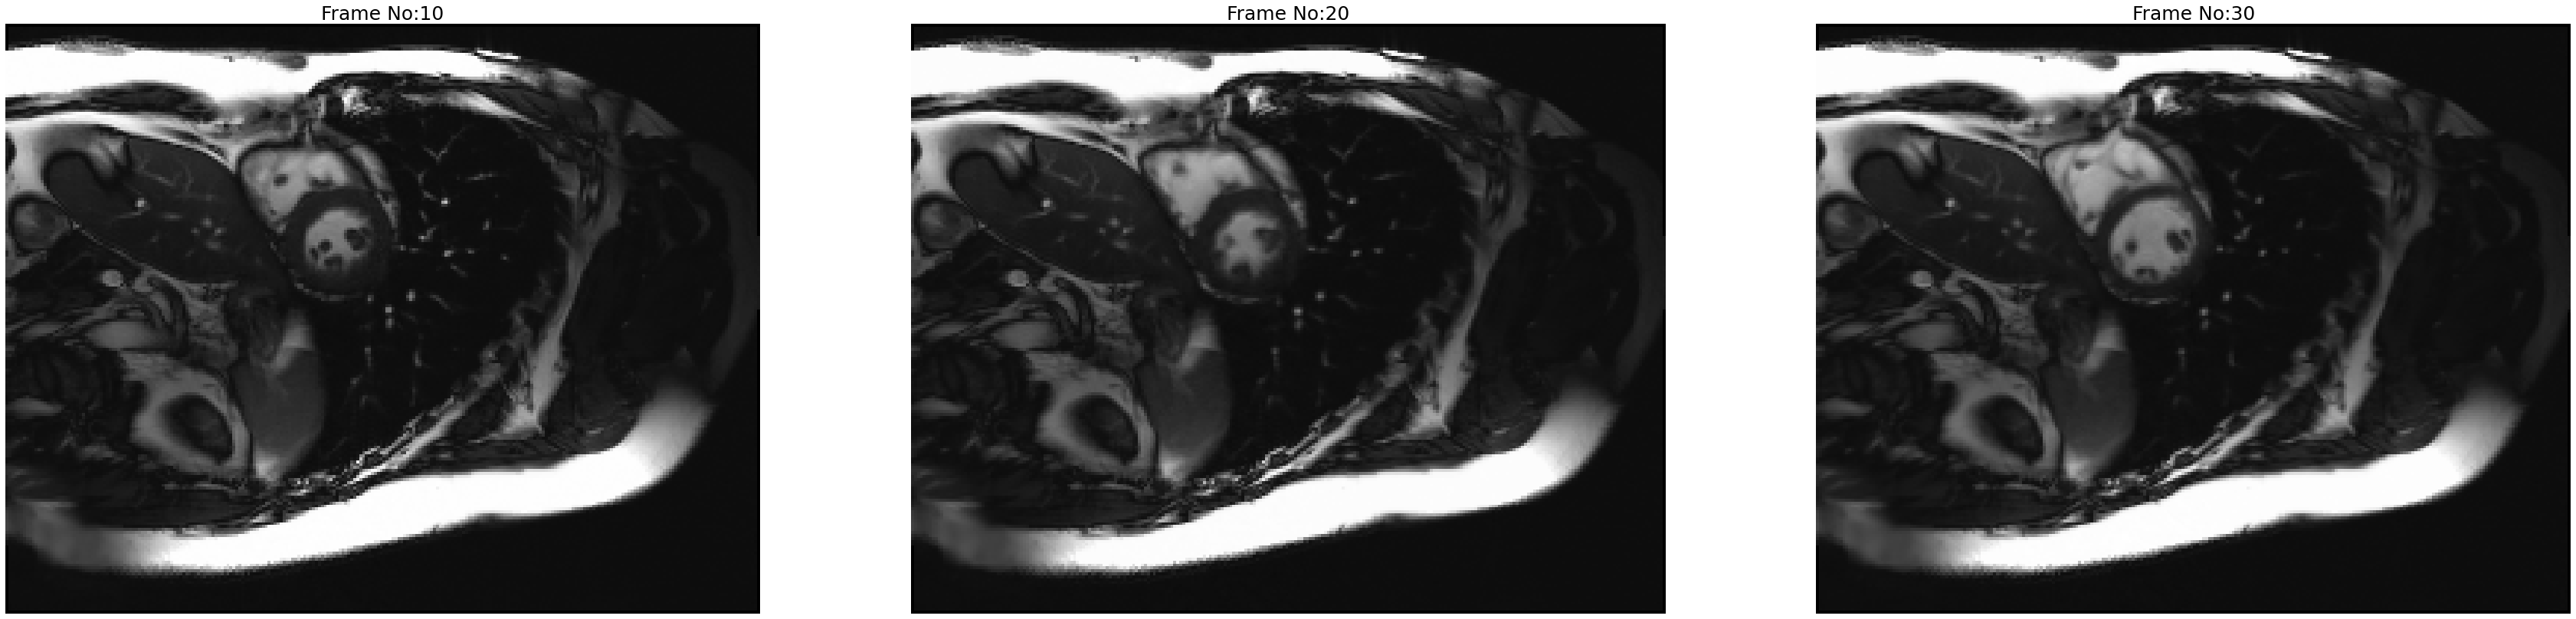

In [145]:
display_random_images(np.abs(reshaped_recon))

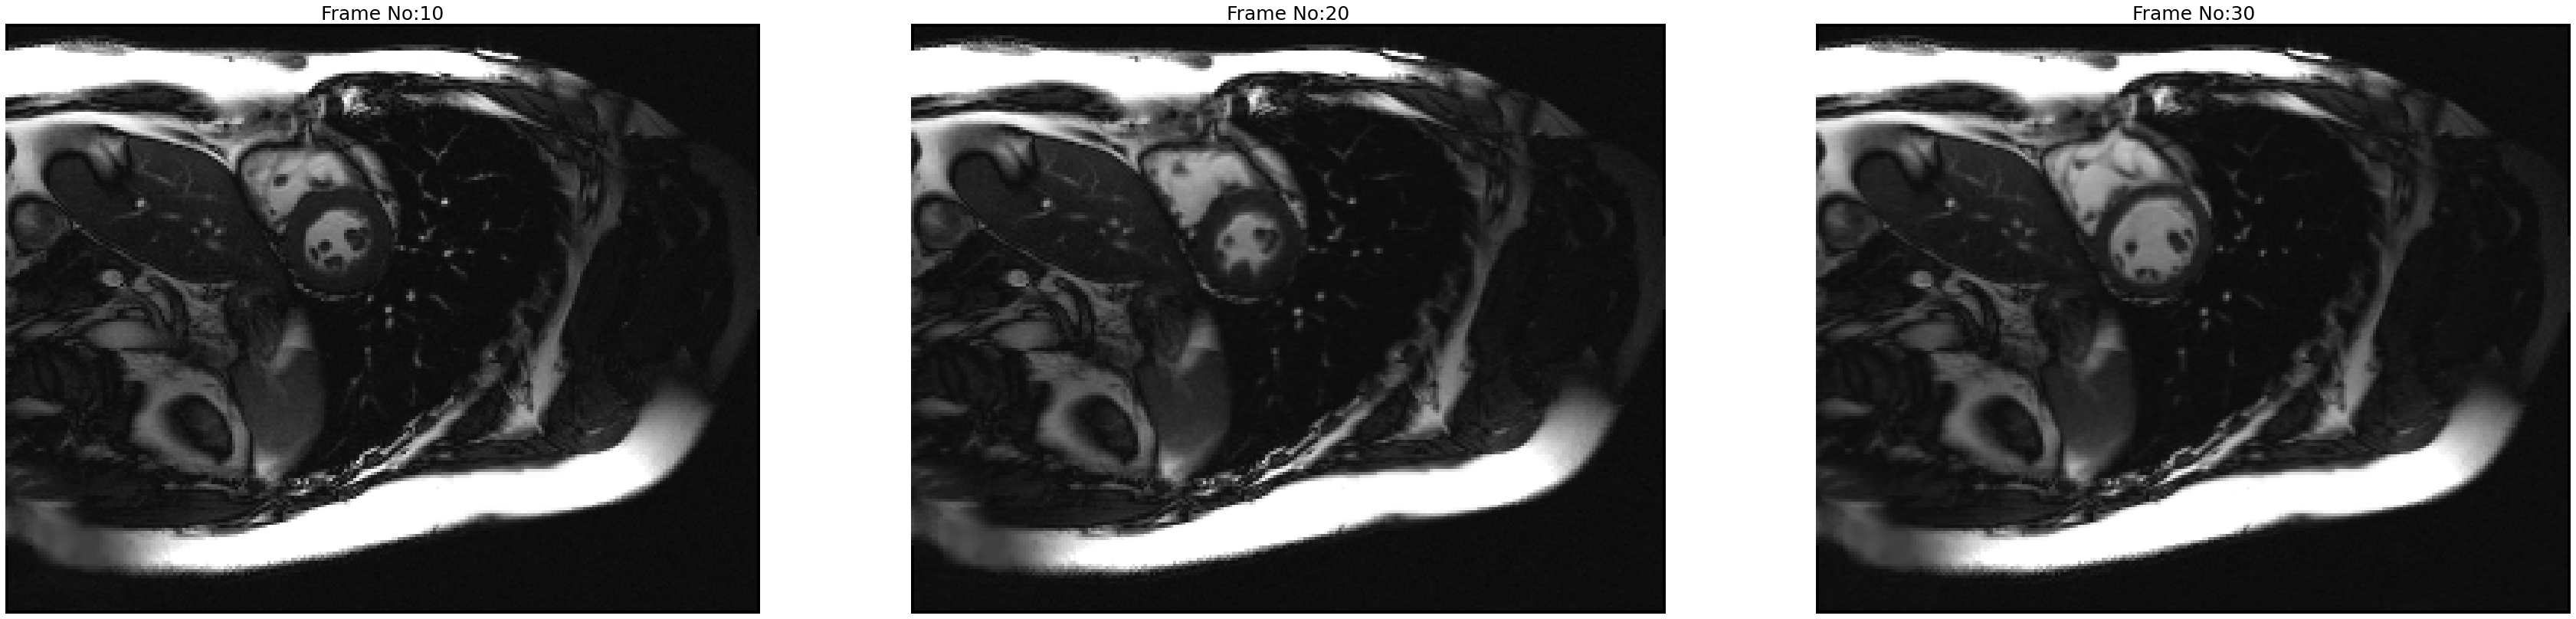

In [146]:
display_random_images(image)

In [147]:
#display undersampled data 
d_full=np.zeros_like(Kraw)
d_full[Mask.reshape(Np,Nf,Nfr)]=Kraw[Mask.reshape(Np,Nf,Nfr)]
d_full=np.sqrt(Np*Nf)*np.fft.ifft2(d_full,axes=(0,1))

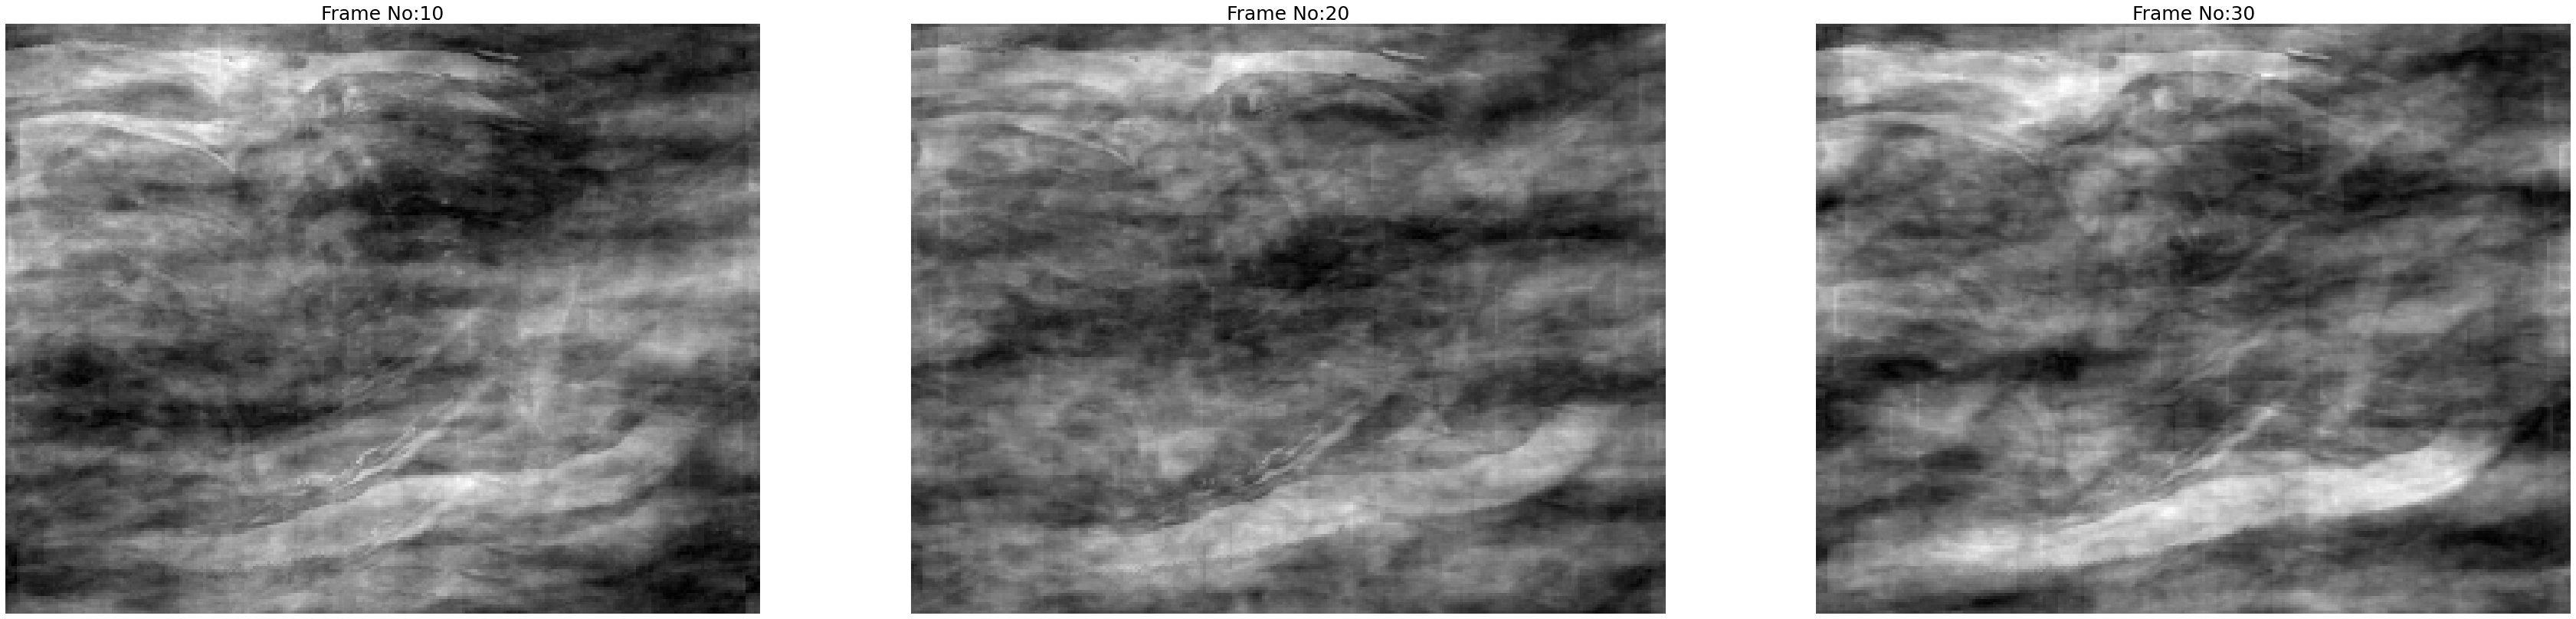

In [148]:
display_random_images(np.abs(d_full))